# Binary Classification Model

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
Epoch: 0 | Loss: 0.6932 | Training Accuracy: 50.00% | Test Loss:0.6941 | Test Accuracy:50.00%
Epoch: 100 | Loss: 0.6906 | Training Accuracy: 52.62% | Test Loss:0.6922 | Test Accuracy:50.00%
Epoch: 200 | Loss: 0.6887 | Training Accuracy: 53.00% | Test Loss:0.6911 | Test Accuracy:49.00%
Epoch: 300 | Loss: 0.6868 | Training Accuracy: 52.50% | Test Loss:0.6898 | Test Accuracy:50.50%
Epoch: 400 | Loss: 0.6839 | Training Accuracy: 57.75% | Test Loss:0.6875 | Test Accuracy:58.00%
Epoch: 500 | Loss: 0.6797 | Training Accuracy: 63.00% | Test Loss:0.6841 | Test Accuracy:64.50%
Epoch: 600 | Loss: 0.6730 | Training Accuracy: 62.75% | Test Loss:0.6788 | Test Accuracy:61.00%
Epoch: 700 | Loss: 0.6629 | Training Accuracy: 65.00% | Test Loss:0.6707 | Test Accuracy:60.50%
Epoch: 800 | Loss: 0.6469 | Training Accurac

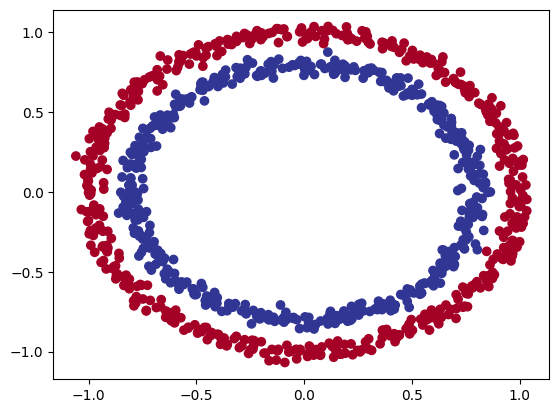

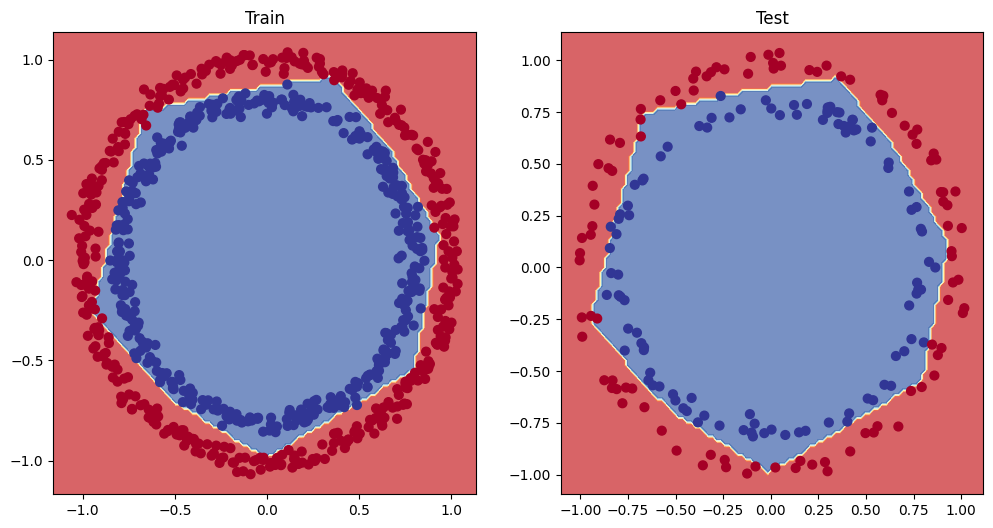

In [2]:
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

n_samples = 1000
X,y = make_circles(n_samples, noise=0.03, random_state=42)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
# X[:0] has x coordinates of the circle, X[:,1] has y coordinates of the circle, y contains the index (blue,red) of the circle

plt.scatter(x=X[:,0], y = X[:,1], c=y, cmap=plt.cm.RdYlBu)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


# Importing Plotting Helper Functions

import requests # Getting code from the internet
from pathlib import Path

# Download helper functions from Learn_PyTorch repo

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


import torch
from torch import nn
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features=10)
    self.layer_3 = nn.Linear(in_features = 10, out_features=1)
    self.relu = nn.ReLU()
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

BCModel = CircleModel().to(device)


with torch.inference_mode():
  untrained_logits = BCModel(X_test)
  untrained_preds = torch.round(torch.sigmoid(untrained_logits))
print(untrained_preds[:10])
print(y_test[:10])

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # How many are correct
  acc = (correct/len(y_pred))*100
  return acc

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(BCModel.parameters(), lr=0.1)

epochs = 2000
for epoch in range(epochs):
  BCModel.train()
  y_logits = BCModel(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  acc = accuracy_fn(y_train, y_preds)
  loss = loss_fn(y_logits, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  BCModel.eval()
  with torch.inference_mode():
    test_logits = BCModel(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Training Accuracy: {acc:.2f}% | Test Loss:{test_loss:.4f} | Test Accuracy:{test_acc:.2f}%")

# Plot decision boundaries
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(BCModel, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(BCModel, X_test, y_test)
